In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
import os
import dsc
from dsc.query_engine import Query_Processor as dscQP
from dsc import dsc_io

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

import utils

In [2]:
def stratify_dfcol(df, colname, value):
    #return pd_utils.select_dfrows(df, [f"$({colname}) == {value}"])
    return df.loc[df[colname] == value]

def stratify_dfcols(df, condition_list):
    for (colname, value) in condition_list:
        df = stratify_dfcol(df, colname, value)
    return df

def stratify_dfcols_in_list(df, colname, values):
    return df.loc[df[colname].isin(values)]

In [24]:
dsc_output = "/home/saikatbanerjee/scratch/work/gradvi-experiments/linreg_corr_init"
dsc_fname  = os.path.basename(os.path.normpath(dsc_output))
db = os.path.join(dsc_output, dsc_fname + ".db")
elbopkl   = os.path.join("../dsc/results", dsc_fname + "_elbo.pkl")
dscoutpkl = os.path.join("../dsc/results", dsc_fname + "_dscout.pkl")
msepkl    = os.path.join("../dsc/results", dsc_fname + "_mse.pkl")
niterpkl  = os.path.join("../dsc/results", dsc_fname + "_niter.pkl")
dscout    = pd.read_pickle(dscoutpkl)

refresh_pickle = True

print(db)
plotprefix = "compare_niter_linreg_blockcorr"

/home/saikatbanerjee/scratch/work/gradvi-experiments/linreg_corr_init/linreg_corr_init.db


In [25]:
target = ["simulate", "simulate.sfix", "simulate.pve", "simulate.se", "simulate.dims", "fit"]
#condition = ["simulate.sfix == 2", "simulate.signal == 'normal'", "simulate.dims == '(50, 200)'"]
#groups = ["fit_cpt:"]
condition = [""]

In [26]:
qp = dscQP(db, target, condition)
df = qp.output_table
df

,DSC,simulate,simulate.sfix,simulate.se:output,simulate.pve,simulate.output.file,simulate.dims,fit,fit.output.file
0,1,blockdiag,2,blockdiag/blockdiag_1,0.4,blockdiag/blockdiag_1,"(500,10000)",mr_ash,mr_ash/blockdiag_1_mr_ash_1
1,1,blockdiag,5,blockdiag/blockdiag_2,0.4,blockdiag/blockdiag_2,"(500,10000)",mr_ash,mr_ash/blockdiag_2_mr_ash_1
2,1,blockdiag,10,blockdiag/blockdiag_3,0.4,blockdiag/blockdiag_3,"(500,10000)",mr_ash,mr_ash/blockdiag_3_mr_ash_1
3,1,blockdiag,20,blockdiag/blockdiag_4,0.4,blockdiag/blockdiag_4,"(500,10000)",mr_ash,mr_ash/blockdiag_4_mr_ash_1
4,1,blockdiag,2,blockdiag/blockdiag_5,0.6,blockdiag/blockdiag_5,"(500,10000)",mr_ash,mr_ash/blockdiag_5_mr_ash_1
...,...,...,...,...,...,...,...,...,...
715,10,blockdiag,20,blockdiag/blockdiag_116,0.6,blockdiag/blockdiag_116,"(500,10000)",gradvi_compound_lasso_init,gradvi_compound_lasso_init/blockdiag_116_lasso...
716,10,blockdiag,2,blockdiag/blockdiag_117,0.8,blockdiag/blockdiag_117,"(500,10000)",gradvi_compound_lasso_init,gradvi_compound_lasso_init/blockdiag_117_lasso...
717,10,blockdiag,5,blockdiag/blockdiag_118,0.8,blockdiag/blockdiag_118,"(500,10000)",gradvi_compound_lasso_init,gradvi_compound_lasso_init/blockdiag_118_lasso...
718,10,blockdiag,10,blockdiag/blockdiag_119,0.8,blockdiag/blockdiag_119,"(500,10000)",gradvi_compound_lasso_init,gradvi_compound_lasso_init/blockdiag_119_lasso...


In [32]:
def read_result(df, method):
    '''
    must be a single row after method selection
    '''
    dfm = stratify_dfcol(df, "fit", method)
    assert(dfm.shape[0] == 1)
    fprefix = dfm['fit.output.file'].values[0]
    ext = 'pkl' if method.startswith('gradvi') else 'rds'
    fname = os.path.join(dsc_output, f"{fprefix}.{ext}")
    data = dsc_io.load_dsc(fname)
    return data

def get_niter_from_result(data, method):
    if method.startswith('gradvi'):
        return data['model']['niter']
    else:
        return data['model']['fit']['iter']
    

def get_convergence_from_result(data, method, mrash_maxiter = 2000):
    '''
    1: converged
    2: abnormal termination
    3: number of iterations reached limit
    4: unknown
    '''
    if method.startswith('gradvi'):
        success = data['model']['success']
        if success:
            conv_status = 1
        else:
            conv_message = data['model']['fitobj']['message']
            if "ITERATIONS REACHED LIMIT" in conv_message:
                conv_status = 3
            elif "ABNORMAL_TERMINATION_IN_LNSRCH" in conv_message:
                conv_status = 2
            else:
                conv_status = 4
    else:
        niter = data['model']['fit']['iter']
        if niter == mrash_maxiter:
            conv_status = 3
        else:
            conv_status = 1
    return conv_status

    
def get_niter_df(df):
    methods = df['fit'].unique()
    sfixs   = df['simulate.sfix'].unique()
    pves    = df['simulate.pve'].unique()
    resdict = {'simulate.sfix': [], 'simulate.pve': [], 'DSC': [], 
               **{x: [] for x in methods}, 
               **{f"{x}_status": [] for x in methods}
              }
    for pve in pves:
        for sfix in sfixs:
            dfs = stratify_dfcols(df, [('simulate.sfix', sfix), ("simulate.pve", pve)])

            dscids = dfs['DSC'].unique()
            for idsc in dscids:
                dfs0 = stratify_dfcol(dfs, 'DSC', idsc)
                resdict['simulate.sfix'].append(sfix)
                resdict['simulate.pve'].append(pve)
                resdict['DSC'].append(idsc)
                for method in methods:
                    data = read_result(dfs0, method)
                    niter = get_niter_from_result(data, method)
                    conv_status = get_convergence_from_result(data, method)
                    resdict[method].append(niter)
                    resdict[f"{method}_status"].append(conv_status)
    return pd.DataFrame.from_dict(resdict)

In [33]:
if refresh_pickle:
    niterdf = get_niter_df(df)
    niterdf.to_pickle(niterpkl)
else:
    niterdf = pd.read_pickle(niterpkl)

In [34]:
elbodf = pd.read_pickle(elbopkl)

In [35]:
niterdf

,simulate.sfix,simulate.pve,DSC,mr_ash,mr_ash_lasso_init,gradvi_direct,gradvi_compound,gradvi_direct_lasso_init,gradvi_compound_lasso_init,mr_ash_status,mr_ash_lasso_init_status,gradvi_direct_status,gradvi_compound_status,gradvi_direct_lasso_init_status,gradvi_compound_lasso_init_status
0,2,0.4,1,60,31,252,521,359,224,1,1,1,1,1,1
1,2,0.4,2,90,58,2000,202,439,119,1,1,3,1,1,1
2,2,0.4,3,82,77,980,226,337,121,1,1,1,1,1,1
3,2,0.4,4,108,84,282,140,325,59,1,1,1,1,1,1
4,2,0.4,5,95,68,956,143,435,76,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,20,0.8,6,311,292,347,194,1576,118,1,1,1,1,1,1
116,20,0.8,7,144,191,817,240,697,154,1,1,1,1,1,1
117,20,0.8,8,145,109,1189,195,1198,189,1,1,1,1,1,1
118,20,0.8,9,151,139,645,318,818,112,1,1,1,1,1,1


0       31
1       58
2       77
3       84
4       68
      ... 
115    292
116    191
117    109
118    139
119     84
Name: mr_ash_lasso_init, Length: 120, dtype: int32

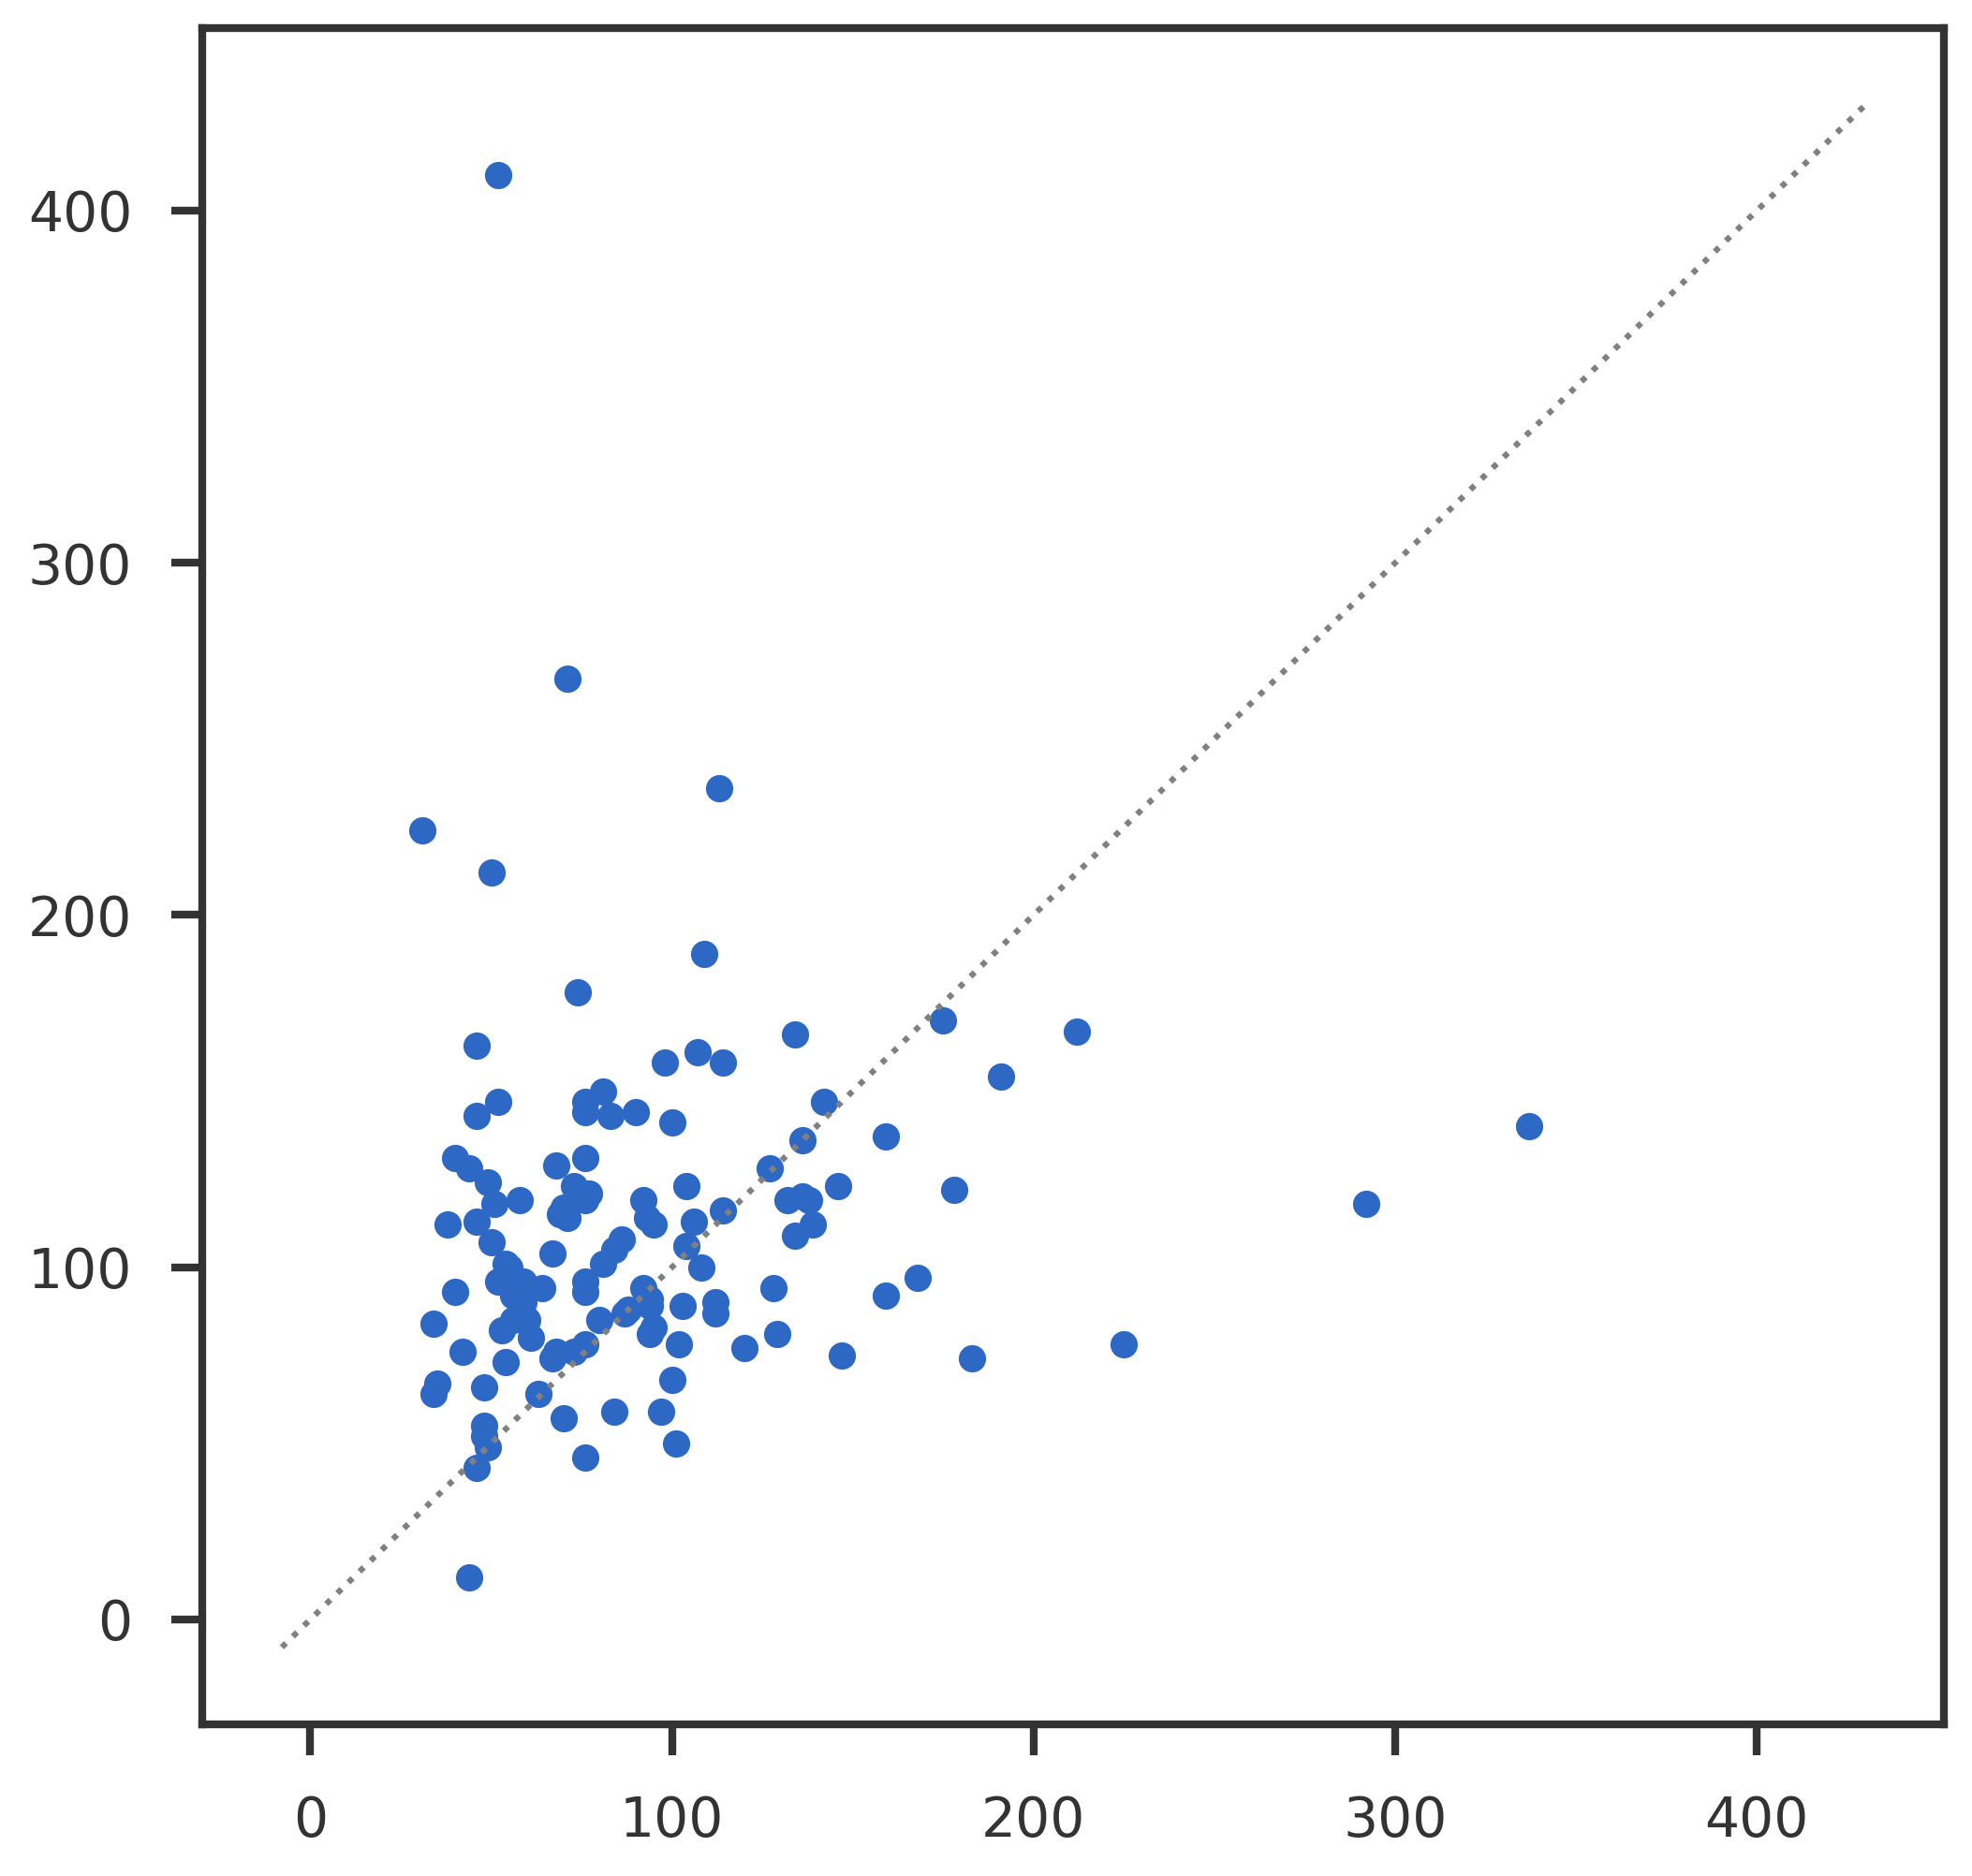

In [44]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(niterdf['mr_ash_lasso_init'], niterdf['gradvi_compound_lasso_init'])
mpl_utils.plot_diag(ax1)
plt.show()